In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA

## Импорт данных

In [2]:
data = pd.read_csv('/content/drive/MyDrive/sasha_test/segmentation.csv')
data = data.fillna(0)
data.head()

,group,grand_tot_interests,interest1,interest2,interest3,interest4,interest5,interest6,interest7,interest8,interest9,interest10,interest11,interest12,interest13,interest14,interest15,interest16,interest17,interest18,interest19,interest20,interest21,interest22,interest23,interest24,interest25,interest26,interest27,interest28,interest29,interest30,interest31,interest32,interest33,interest34,interest35,interest36,interest37,interest38,...,interest178,interest179,interest180,interest181,interest182,interest183,interest184,interest185,interest186,interest187,interest188,interest189,interest190,interest191,interest192,interest193,interest194,interest195,interest196,interest197,interest198,interest199,interest200,interest201,interest202,interest203,interest204,interest205,interest206,interest207,interest208,interest209,interest210,interest211,interest212,interest213,interest214,interest215,interest216,interest217
0,C,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C,43,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,C,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,C,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,C,36,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Анализ интересов

In [3]:
data['group'].value_counts()

I    1809
P    1731
C    1725
R    1075
Name: group, dtype: int64

Посчитаем среднее значение по признакам для каждой из групп. 
* Получившиеся значения равны долям людей в группе, которые отметили данный *interest*.  

In [4]:
agregated_means = data.groupby('group')[data.columns[1:]].apply(lambda x: x.mean())
agregated_means

,grand_tot_interests,interest1,interest2,interest3,interest4,interest5,interest6,interest7,interest8,interest9,interest10,interest11,interest12,interest13,interest14,interest15,interest16,interest17,interest18,interest19,interest20,interest21,interest22,interest23,interest24,interest25,interest26,interest27,interest28,interest29,interest30,interest31,interest32,interest33,interest34,interest35,interest36,interest37,interest38,interest39,...,interest178,interest179,interest180,interest181,interest182,interest183,interest184,interest185,interest186,interest187,interest188,interest189,interest190,interest191,interest192,interest193,interest194,interest195,interest196,interest197,interest198,interest199,interest200,interest201,interest202,interest203,interest204,interest205,interest206,interest207,interest208,interest209,interest210,interest211,interest212,interest213,interest214,interest215,interest216,interest217
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C,35.853333,0.162319,0.000000,0.009855,0.005797,0.176812,0.498551,0.000000,0.013913,0.049275,0.00058,0.037681,0.702609,0.004638,0.049855,0.263768,0.706667,0.063188,0.000580,0.019130,0.027246,0.588986,0.056812,0.008116,0.009275,0.002899,0.004058,0.000000,0.005217,0.016812,0.016232,0.000000,0.006377,0.048696,0.00058,0.000000,0.002319,0.004638,0.005797,0.001159,...,0.009275,0.024348,0.623768,0.113043,0.000000,0.965797,0.00058,0.000000,0.037681,0.131014,0.023768,0.551304,0.001159,0.001159,0.026087,0.011014,0.042319,0.033623,0.324058,0.072464,0.008116,0.004638,0.525797,0.177971,0.249855,0.004058,0.025507,0.027246,0.001739,0.00000,0.019710,0.037681,0.740870,0.281159,0.113043,0.000580,0.035362,0.727536,0.577971,0.027826
I,40.767828,0.181868,0.000553,0.004422,0.003317,0.124931,0.570481,0.000000,0.020453,0.055832,0.00000,0.030956,0.682698,0.001658,0.061360,0.301271,0.673853,0.046987,0.000553,0.015478,0.035379,0.711443,0.097844,0.007739,0.008292,0.002764,0.002211,0.000553,0.012161,0.021559,0.014373,0.000000,0.008845,0.044223,0.00000,0.000553,0.000553,0.036484,0.016031,0.001658,...,0.021559,0.014373,0.735213,0.199005,0.000553,0.987286,0.00000,0.001106,0.128800,0.129353,0.037590,0.571034,0.010503,0.001106,0.022664,0.010503,0.054726,0.044223,0.028745,0.009950,0.000000,0.003317,0.814815,0.635158,0.287452,0.003870,0.019348,0.023217,0.000553,0.00000,0.014925,0.010503,0.844666,0.447761,0.174129,0.000553,0.002211,0.854616,0.743505,0.010503
P,35.695552,0.116118,0.000000,0.002311,0.002311,0.109763,0.513576,0.000578,0.010976,0.038706,0.00000,0.015020,0.721548,0.002311,0.057770,0.322935,0.723281,0.047949,0.000000,0.020797,0.016176,0.640670,0.048527,0.005777,0.009243,0.002311,0.002311,0.000578,0.002311,0.030040,0.029463,0.000578,0.012132,0.038706,0.00000,0.000578,0.000578,0.043905,0.006355,0.001733,...,0.006932,0.029463,0.667822,0.109763,0.000000,0.979780,0.00000,0.000578,0.150202,0.120739,0.031774,0.561525,0.001155,0.001733,0.016176,0.011554,0.041017,0.024263,0.025419,0.008088,0.001155,0.005199,0.253611,0.056037,0.218949,0.005199,0.011554,0.013865,0.000578,0.00000,0.020797,0.006355,0.803582,0.487579,0.142692,0.000000,0.002889,0.780474,0.658579,0.023686
R,36.441860,0.170233,0.000000,0.005581,0.004651,0.072558,0.572093,0.000000,0.012093,0.075349,0.00000,0.026047,0.767442,0.002791,0.063256,0.309767,0.765581,0.055814,0.000000,0.040930,0.024186,0.636279,0.064186,0.015814,0.007442,0.002791,0.002791,0.000000,0.003721,0.013953,0.025116,0.000000,0.016744,0.067907,0.00000,0.000930,0.001860,0.010233,0.015814,0.001860,...,0.008372,0.022326,0.689302,0.100465,0.000000,0.964651,0.00000,0.000000,0.038140,0.163721,0.041860,0.549767,0.000000,0.001860,0.011163,0.019535,0.047442,0.013023,0.039070,0.009302,0.000000,0.013023,0.469767,0.109767,0.289302,0.002791,0.017674,0.020465,0.001860,0.00093,0.020465,0.013953,0.784186,0.313488,0.113488,0.000000,0.001860,0.736744,0.536744,0.036279


Заметно, что пользователи из категории I в среднем имеют на 5 интересов больше, чем пользователи остальных групп.

## Гипотеза
#### *Ключевые интересы каждой группы соответствуют наибольшим весам в логистической регрессии*

Каждая из групп пользователей должна определяться своими ключевыми признаками - характерными для них интересами. Такие интересы определяют отношение пользователя к конкретной группе. Значит при классификации эти интересы должны стать более важными признаками, чем другие, нехарактерные для групп интересы.

Т.е. в модели логистической регрессии значения более важных признаков должны складываться с бОльшими весами. Следовательно, если найти наибольшие веса ЛогРега, то можно определить какие признаки наиболее важны для каждой группы.

In [ ]:
from sklearn.linear_model import LogisticRegression

labels = {'I':0, 'R':1, 'P':2, 'C':3}
# drop column with groups
X = data[data.columns[1:]]
# change letters to labels
y = [labels[label] for label in data['group']]

model = LogisticRegression(random_state=0).fit(X, y)

Оценим насколько точно модель смогла обучиться под данные.

In [6]:
y_pred = model.predict(X)
print("Accuracy: ", metrics.accuracy_score(y_pred, y))

Accuracy:  0.6102523659305994


Теперь извлечем веса ЛогРега и определим признаки, которые соответствуют наибольшим весам. 

### Группа I

In [7]:
num_interests = 3

weights_I = model.coef_[0]
idxs_I = np.argsort(weights_I)[-num_interests:][::-1]
interests_I = [X.columns[idx] for idx in idxs_I]

print(weights_I[idxs_I]) 
print(interests_I)

[1.35037994 0.80733071 0.70560321]
['interest201', 'interest200', 'interest91']


### Группа R

In [8]:
weights_R = model.coef_[1]
idxs_R = np.argsort(weights_R)[-num_interests:][::-1]
interests_R = [X.columns[idx] for idx in idxs_R]

print(weights_R[idxs_R]) 
print(interests_R)

[0.54760546 0.48611353 0.38064387]
['interest88', 'interest109', 'interest153']


### Группа P

In [9]:
weights_P = model.coef_[2]
idxs_P = np.argsort(weights_P)[-num_interests:][::-1]
interests_P = [X.columns[idx] for idx in idxs_P]

print(weights_P[idxs_P]) 
print(interests_P)

[0.91605159 0.73882026 0.48607305]
['interest48', 'interest186', 'interest211']


### Группа C

In [10]:
weights_C = model.coef_[3]
idxs_C = np.argsort(weights_C)[-10:][::-1]
interests_C = [X.columns[idx] for idx in idxs_C[:3]]

print(weights_C[idxs_C]) 
print(interests_C)

[1.33656817 0.59877483 0.5855577  0.34646323 0.27883361 0.22550938
 0.22282046 0.17420783 0.16459969 0.16058756]
['interest196', 'interest102', 'interest135']


Соберем признаки вместе

In [11]:
common_interests = set(interests_C) | set(interests_I) | set(interests_P) | set(interests_R)
common_interests

{'interest102',
 'interest109',
 'interest135',
 'interest153',
 'interest186',
 'interest196',
 'interest200',
 'interest201',
 'interest211',
 'interest48',
 'interest88',
 'interest91'}

## Проверка гипотезы
Допустим, что извлеченные признаки действительно являются ключевыми для групп.

Тогда ЛогРег, обученный только на этих признаках должен иметь accuracy схожее с тем, что было достигнуто моделью, обученной на всех признаках. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X[common_interests], y, 
                                                    test_size=0.2)

model = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: ", metrics.accuracy_score(y_pred, y_test))

Accuracy:  0.5725552050473186


Полученное accuracy (0.597) близко к accuracy, достигнутом моделью, обученной на всех признаках (0.61). Исходя из этого, можно сделать вывод:

**Найденные интересы-признаки несут в себе существенную информацию об отношении пользователей к конкретной группе**

Тогда характерными для групп интересами являются:

* Группа I: **interest201**,  **interest200**,  **interest91**
* Группа R: **interest88**,  **interest109**,  **interest153**
* Группа P: **interest48**,  **interest186**,  **interest211**
* Группа C: **interest196**,  **interest102**,  **interest135**

## Альтернативный способ поиска ключевых интересов
Определим характерный для группы интерес как признак, который пользователи данной группы часто отмечают (например 60% пользователей группы), а пользователи остальных групп нет. 

Пусть один признак-интерес свойственнен одной или двум группам. В противном случае, если пользователи всех групп часто отмечают данный признак, то он не является характерным для какой-то одной группы.

In [14]:
essential_interests = []
for column in agregated_means:
    if 0 < sum(agregated_means[column] >= 0.6) < 3:
        essential_interests.append(column)

agregated_means[essential_interests]

,interest63,interest66,interest90,interest92,interest127,interest164,interest200,interest201,interest216
group,,,,,,,,,
C,0.458551,0.621449,0.514783,0.518261,0.507246,0.559420,0.525797,0.177971,0.577971
I,0.642344,0.735213,0.545605,0.617468,0.632394,0.810945,0.814815,0.635158,0.743505
P,0.451184,0.582900,0.614674,0.573657,0.573079,0.693819,0.253611,0.056037,0.658579
R,0.510698,0.574884,0.599070,0.587907,0.601860,0.549767,0.469767,0.109767,0.536744


Выделим для каждой группы те интересы, которые имеют наибольшие доли среди других групп.
* Группа I: **interest63**,  **interest66**,  **interest164**, **interest200**, **interest216**
* Группа R: **interest127**,  **interest90**,  **interest63**
* Группа P: **interest90**,  **interest164**,  **interest216**
* Группа C: **interest66**,  **interest200**,  **interest201**

## Кластеризация
Выберем кластеризатор на основе метрики *silhouette*

In [16]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

algorithms = []
algorithms.append(KMeans(n_clusters=4, random_state=42))
algorithms.append(AgglomerativeClustering(n_clusters=4))
algorithms.append(SpectralClustering(n_clusters=4, random_state=42,
                                     affinity='nearest_neighbors'))

X = data[data.columns[1:]]
metric_ = []
for algo in algorithms:
    algo.fit(X)
    metric_.append(({
        'Silhouette': metrics.silhouette_score(X, algo.labels_)}))

results = pd.DataFrame(data=metric_, columns=['Silhouette'],
                       index=['K-means', 'Spectral', 'Agglomerative'])
results

,Silhouette
K-means,0.407501
Spectral,0.391394
Agglomerative,0.399977


Уменьшим размерность при помощи метода главных компонент для визуализации кластеров 

In [18]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X) 

### Визуализация исходного разбиения по группам

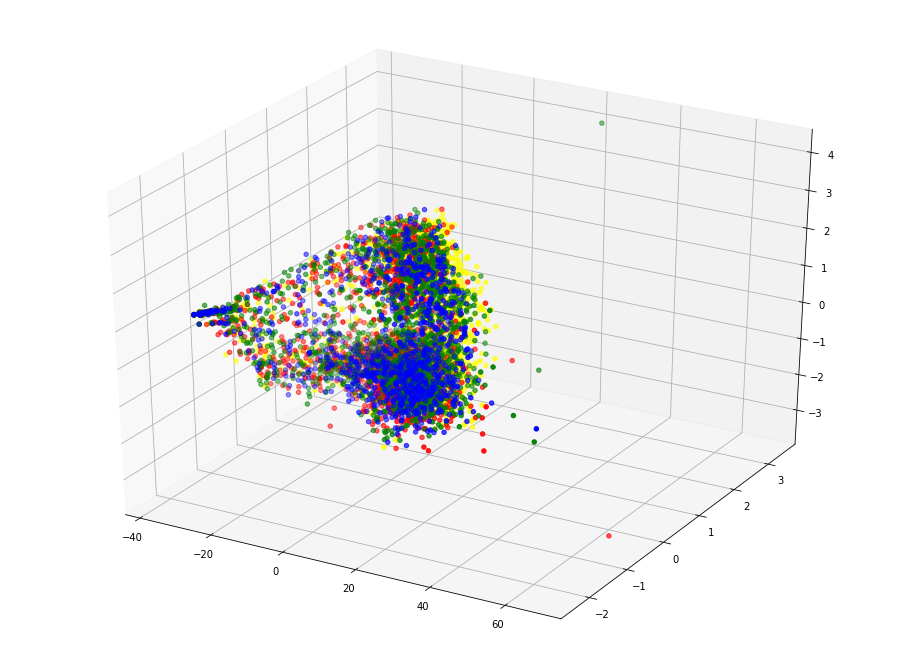

In [21]:
pca_C = pca.transform(data[data['group'] == 'C'][data.columns[1:]])
pca_R = pca.transform(data[data['group'] == 'R'][data.columns[1:]])
pca_I = pca.transform(data[data['group'] == 'I'][data.columns[1:]])
pca_P = pca.transform(data[data['group'] == 'P'][data.columns[1:]])

ax = plt.figure(figsize=(16, 12)).gca(projection='3d')
ax.scatter(xs=pca_I[:, 0], ys=pca_I[:, 2], zs=pca_I[:, 1], 
           cmap='tab10', c = 'yellow')

ax.scatter(xs=pca_C[:, 0], ys=pca_C[:, 2], zs=pca_C[:, 1], 
           cmap='tab10', c = 'green')

ax.scatter(xs=pca_P[:, 0], ys=pca_P[:, 2], zs=pca_P[:, 1],  
           cmap='tab10', c = 'red')

ax.scatter(xs=pca_R[:, 0], ys=pca_R[:, 2], zs=pca_R[:, 1], 
           cmap='tab10', c = 'blue')
plt.show()

Группы распределены слоями, группы P и C (красный и зеленый) сильно смешаны между собой.

### Визуализация результата кластеризации

In [22]:
def clusters_vizualization(X, X_pca, features, Algorithm, 
                           colors=['red', 'blue', 'green', 'yellow']):
  
    algo = Algorithm.fit(X[features])
    labels = algo.labels_

    ax = plt.figure(figsize=(16, 12)).gca(projection='3d')
    ax.scatter(
        xs=X_pca[:, i][labels == 0], 
        ys=X_pca[:, j][labels == 0], 
        zs=X_pca[:, k][labels == 0], 
        cmap='tab10', 
        c=colors[0])

    ax.scatter(
        xs=X_pca[:, i][labels == 1], 
        ys=X_pca[:, j][labels == 1], 
        zs=X_pca[:, k][labels == 1], 
        cmap='tab10', 
        c=colors[1])

    ax.scatter(
        xs=X_pca[:, i][labels == 2], 
        ys=X_pca[:, j][labels == 2], 
        zs=X_pca[:, k][labels == 2],
        cmap='tab10', 
        c=colors[2])

    ax.scatter(
        xs=X_pca[:, i][labels == 3], 
        ys=X_pca[:, j][labels == 3], 
        zs=X_pca[:, j][labels == 3],
        cmap='tab10', 
        c=colors[3])
    plt.show()

i,j,k = (0,2,1) #axis indexes
colors = ['red', 'green', 'blue', 'yellow']

Разбиение по кластерам не похоже на исходное разбиение. На вход алгоритму KMeans подавался датасет со всеми признаками-интересами.

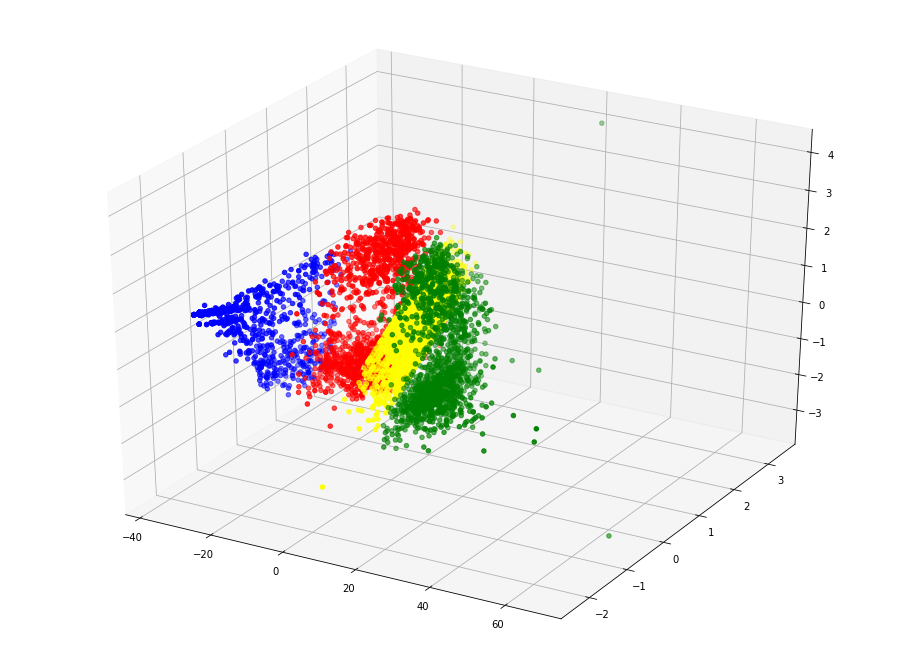

In [23]:
clusters_vizualization(X, X_pca, X.columns, KMeans(n_clusters=4, random_state=42), colors)

Если на вход KMeans подать датасет только с теми признаками-интересами, которые были найдены при помощи весов логистической регрессии, то разбиение на кластеры больше похоже на исходные группы.

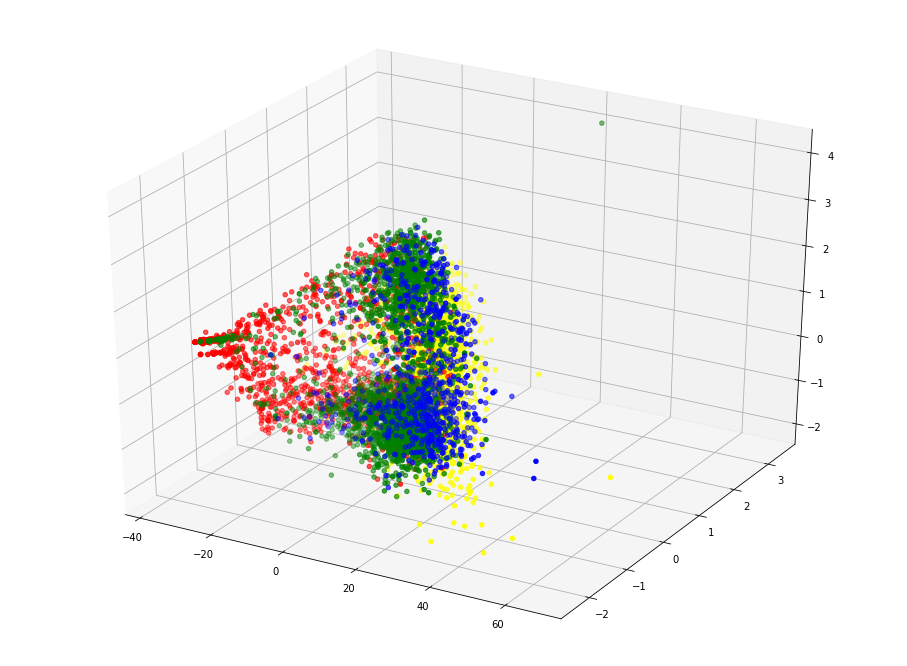

In [24]:
clusters_vizualization(X, X_pca, common_interests, KMeans(n_clusters=4, random_state=42), colors)